In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy, mean_absolute_error, mae
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.utils import Sequence


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import glob
import cv2
import sys
import import_ipynb
from tqdm import tqdm, trange

Using TensorFlow backend.


In [2]:
input_shape=(84, 84, 3)
latent_dim = 100
inputs = Input(shape=input_shape, name='denoising_encoder_input')
x_inputs = Conv2D(filters=32, kernel_size=4, activation='relu', strides=2,
                  padding='same')(inputs)
x_inputs = Conv2D(filters=32, kernel_size=4, activation='relu', strides=2,
                  padding='same')(x_inputs)
x_inputs = Conv2D(filters=64, kernel_size=4, activation='relu', strides=2,
                  padding='same')(x_inputs)
x_inputs = Conv2D(filters=64, kernel_size=4, activation='relu', strides=2,
                  padding='same')(x_inputs)

x_inputs = Flatten()(x_inputs)
z = Dense(latent_dim, name='z', activation='linear')(x_inputs)

# instantiate encoder model
encoder = Model(inputs, z, name='denoising_encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,))
x_decoder = Dense(6 * 6 * 64, activation='relu')(latent_inputs)
x_decoder = Reshape((6, 6, 64))(x_decoder)

x_decoder = Conv2DTranspose(filters=64, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)
x_decoder = Conv2DTranspose(filters=64, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)
x_decoder = Conv2DTranspose(filters=32, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)
x_decoder = Conv2DTranspose(filters=32, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)

x_decoder = Conv2DTranspose(filters=3, kernel_size=1, strides=1,
                            activation='linear', padding='same')(x_decoder)
x_decoder = Lambda(lambda x: x[:, :84, :84, :])(x_decoder)

# instantiate decoder model
decoder = Model(latent_inputs, x_decoder, name='denoising_decoder')
decoder.summary()

# instantiate VAE model
denoising = Model(inputs, decoder(encoder(inputs)), name='denoising')
denoising.load_weights("denoising_autoencoder.h5")

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
denoising_encoder_input (Inp (None, 84, 84, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        1568      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        16416     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          65600     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
z (D

In [3]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    # return z_mean + K.exp(0.5 * z_log_var) * epsilon
    return z_mean

In [4]:
# network parameters
latent_dim = 32
input_shape = (84, 84, 3)

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x_inputs = Conv2D(filters=32, kernel_size=4, activation='relu', strides=2,
                  padding='same')(inputs)
x_inputs = Conv2D(filters=32, kernel_size=4, activation='relu', strides=2,
                  padding='same')(x_inputs)
x_inputs = Conv2D(filters=64, kernel_size=4, activation='relu', strides=2,
                  padding='same')(x_inputs)
x_inputs = Conv2D(filters=64, kernel_size=4, activation='relu', strides=2,
                  padding='same')(x_inputs)

x_inputs = Flatten()(x_inputs)
x_inputs = Dense(256, activation='relu')(x_inputs)
z_mean = Dense(latent_dim, name='z_mean', activation='linear')(x_inputs)
z_log_var = Dense(latent_dim, name='z_log_var', activation='linear')(x_inputs)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


# build decoder model
latent_inputs = Input(shape=(latent_dim,))
x_decoder = Dense(256, activation='relu')(latent_inputs)
x_decoder = Dense(6 * 6 * 64, activation='relu')(x_decoder)
x_decoder = Reshape((6, 6, 64))(x_decoder)

x_decoder = Conv2DTranspose(filters=64, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)
x_decoder = Conv2DTranspose(filters=64, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)
x_decoder = Conv2DTranspose(filters=32, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)
x_decoder = Conv2DTranspose(filters=32, kernel_size=4, activation='relu',
                            strides=2, padding='same')(x_decoder)

x_decoder = Conv2DTranspose(filters=3, kernel_size=1, strides=1,
                            activation='linear', padding='same')(x_decoder)
x_decoder = Lambda(lambda x: x[:, :84, :84, :])(x_decoder)

# instantiate decoder model
decoder = Model(latent_inputs, x_decoder, name='decoder')
decoder.summary()

# instantiate VAE model
encoder_outputs = encoder(inputs)
outputs = [encoder_outputs[0], encoder_outputs[1], decoder(encoder_outputs[2])]
vae = Model(inputs, outputs, name='vae')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 84, 84, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 42, 42, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 21, 21, 32)   16416       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 11, 11, 64)   32832       conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (

In [5]:
denoising_encoder = Model(denoising.inputs, denoising.layers[-2].outputs)
for layer in denoising_encoder.layers:
    layer.trainable = False
denoising_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
denoising_encoder_input (Inp (None, 84, 84, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        1568      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        16416     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          65600     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
z (Dense)                    (None, 100)               230500    
Total para

In [6]:
def load_small_dataset():
    imgs = np.asarray([cv2.imread(x) for x in tqdm(glob.glob("training_observations2/*.png")[:300])])
    print(imgs.shape)
    x_train = imgs[:128, :]
    x_test = imgs[128:, :]
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    y_train = np.array([])
    y_test = np.array([])
    image_size = imgs.shape[1]
    input_shape = (image_size, image_size, 3)
    
    return x_train, y_train, x_test, y_test, image_size, input_shape

x_train, y_train, x_test, y_test, image_size, input_shape = load_small_dataset()
print(x_train.max())

100%|██████████| 300/300 [00:00<00:00, 4799.16it/s]

(300, 84, 84, 3)
1.0


In [7]:
# reconstruction_loss = mse(denoising_encoder(inputs), denoising_encoder(outputs[2]))
# reconstruction_loss *= 100
reconstruction_loss = K.square(denoising_encoder(inputs) - denoising_encoder(outputs[2]))
reconstruction_loss = K.sum(reconstruction_loss, axis=-1)
beta = 175.
kl_loss = 1 + outputs[0] - K.square(outputs[1]) - K.exp(outputs[0])
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
print(kl_loss, reconstruction_loss)
vae_loss = K.mean(reconstruction_loss + beta * kl_loss)
vae.add_loss(vae_loss)
learning_rate = 1e-4
adam = Adam(lr=learning_rate)
vae.compile(optimizer=adam)
vae.summary()

Tensor("mul:0", shape=(?,), dtype=float32) Tensor("Sum:0", shape=(?,), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 84, 84, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 32), (None, 32),  722944    
_________________________________________________________________
decoder (Model)              (None, 84, 84, 3)         781091    
Total params: 1,504,035
Trainable params: 1,504,035
Non-trainable params: 0
_________________________________________________________________


In [8]:
class DataSequence(Sequence):
    def __init__(self, batch_size=128):
        self.batch_size = batch_size
        self.filenames = glob.glob("training_observations2/*.png")[:100000]
        self.image_size = 84
        self.on_epoch_end()
        
    def on_epoch_end(self):
        np.random.shuffle(self.filenames)
    
    def __len__(self):
        return int(np.floor(len(self.filenames) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_x = np.asarray([cv2.imread(x) for x in self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]])
        batch_x = batch_x.astype('float32') / 255.
        return batch_x, None
        

In [9]:
epochs = 5
batch_size = 10
steps_per_epoch = int(np.round(len(glob.glob("training_observations2/*.png")) / batch_size))
checkpoint = ModelCheckpoint('beta_vae_checkpoint.h5', monitor='val_loss', 
                             verbose=0, save_best_only=True, mode='min', save_weights_only=True)

img_generator = DataSequence(batch_size=batch_size)
history = vae.fit_generator(img_generator, epochs=epochs, 
                            workers=7, callbacks=[checkpoint], validation_data=(x_test, None))

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
10000/10000 [==============================] - 87s 9ms/step - loss: 20.7268 - val_loss: 11.5024
Epoch 2/5
10000/10000 [==============================] - 87s 9ms/step - loss: 9.8764 - val_loss: 9.0213
Epoch 3/5
10000/10000 [==============================] - 87s 9ms/step - loss: 7.6497 - val_loss: 6.9949
Epoch 4/5
10000/10000 [==============================] - 87s 9ms/step - loss: 6.0955 - val_loss: 5.6761
Epoch 5/5
10000/10000 [==============================] - 87s 9ms/step - loss: 5.1361 - val_loss: 4.9784


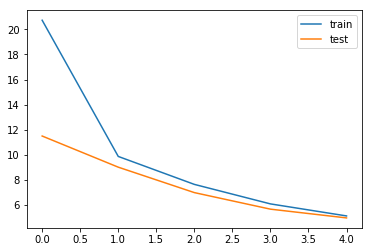

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(['train', 'test'])
plt.show()

In [11]:
vae.save_weights('darla_vae.h5')

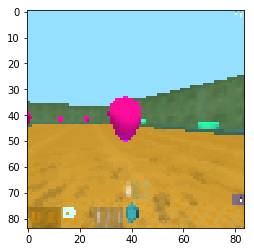

In [12]:
%matplotlib inline
from matplotlib.pyplot import imshow
imshow(x_train[35])

1.0 0.5861411 0.0
1.1590979 0.58824146 -0.117327586


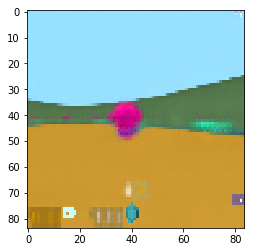

In [13]:
predicted_imgs = vae.predict(x_train, batch_size=batch_size)[2]
print(x_train.max(), x_train.mean(), x_train.min())

if False:
    print(predicted_imgs.max(), predicted_imgs.mean(), predicted_imgs.min())
    predicted_imgs = (predicted_imgs - predicted_imgs.min()) / (predicted_imgs.max() - predicted_imgs.min())
    print(predicted_imgs.max(), predicted_imgs.mean(), predicted_imgs.min())
    imshow(predicted_imgs[118])
else:
    denoised_predicted = denoising.predict(predicted_imgs)
    print(denoised_predicted.max(), denoised_predicted.mean(), denoised_predicted.min())
    denoised_predicted = np.clip(denoised_predicted, 0., 1.)
    imshow(denoised_predicted[35])